### Import libraries and load data from database

In [1]:
#import all libraries
from sqlalchemy import create_engine 
import pandas as pd
import sqlite3
import numpy as np
import pickle
import re
import operator
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import correlation as dc
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error

In [2]:
# load data from database
engine = create_engine('sqlite:///Mobile_DB.db')
df = pd.read_sql_table('Mobiles_Features_Reviews', engine)
df.head()

,brand,mob_name,price,launch_year,GSM,CDMA,HSPA,EVDO,LTE,body_height(mm),...,screen_to_body(%),Android_OS,iOS_OS,Windows_OS,RAM_size(GB),selfie_cam(MP),main_cam(MP),battery(mAh),total_reviews,rating
0,Acer,Liquid Jade Z,129.99,2015.0,1,0,1,0,1,143.5,...,68.8,1,0,0,1.0,5.0,13.0,2300.0,4,1.50
1,Acer,Liquid M2,34.95,2015.0,1,0,1,0,0,124.9,...,57.0,0,0,1,1.0,2.0,5.0,1300.0,15,3.20
2,Apple,iPad 2,129.60,2011.0,0,1,0,1,0,241.2,...,65.1,0,1,0,NaN,NaN,7.0,6930.0,5,3.20
3,Apple,iPad Air,379.99,2019.0,1,0,1,0,1,250.6,...,78.3,0,1,0,3.0,7.0,8.0,NaN,16,3.95
4,Apple,iPad Air 2,211.39,2014.0,1,1,1,1,1,240.0,...,71.6,0,1,0,2.0,2.0,8.0,7340.0,124,4.20


### Discover missing values and features values ranges

In [3]:
# get info about df columns and percentage of missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              660 non-null    object 
 1   mob_name           660 non-null    object 
 2   price              647 non-null    float64
 3   launch_year        654 non-null    float64
 4   GSM                660 non-null    int64  
 5   CDMA               660 non-null    int64  
 6   HSPA               660 non-null    int64  
 7   EVDO               660 non-null    int64  
 8   LTE                660 non-null    int64  
 9   body_height(mm)    657 non-null    float64
 10  body_width(mm)     656 non-null    float64
 11  body_depth(mm)     644 non-null    float64
 12  body_weight(g)     647 non-null    float64
 13  dual_sim           660 non-null    int64  
 14  screen_to_body(%)  646 non-null    float64
 15  Android_OS         660 non-null    int64  
 16  iOS_OS             660 non

In [4]:
# check for min, max and mean values 
df.describe()

,price,launch_year,GSM,CDMA,HSPA,EVDO,LTE,body_height(mm),body_width(mm),body_depth(mm),...,screen_to_body(%),Android_OS,iOS_OS,Windows_OS,RAM_size(GB),selfie_cam(MP),main_cam(MP),battery(mAh),total_reviews,rating
count,647.000000,654.000000,660.000000,660.000000,660.000000,660.000000,660.000000,657.000000,656.000000,644.000000,...,646.000000,660.000000,660.000000,660.000000,406.000000,388.000000,566.000000,642.000000,660.000000,660.000000
mean,296.543617,2013.570336,0.946970,0.201515,0.850000,0.157576,0.507576,134.656925,68.059756,77.520366,...,60.729721,0.696970,0.036364,0.071212,2.679803,6.376289,9.332155,2280.478193,481.451515,3.702498
std,365.518117,3.415186,0.224264,0.401436,0.357342,0.364619,0.500322,23.226886,13.306270,973.547429,...,16.940446,0.459917,0.187335,0.257374,1.733030,5.746376,5.740333,1028.933146,1265.737022,0.567503
min,10.070000,1998.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.800000,39.900000,5.100000,...,13.500000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,300.000000,3.000000,1.000000
25%,99.990000,2011.000000,1.000000,0.000000,1.000000,0.000000,0.000000,116.100000,60.575000,8.300000,...,52.425000,0.000000,0.000000,0.000000,1.000000,2.000000,5.000000,1450.000000,16.750000,3.351915
50%,194.900000,2014.000000,1.000000,0.000000,1.000000,0.000000,1.000000,139.000000,69.500000,9.400000,...,66.400000,1.000000,0.000000,0.000000,2.000000,5.000000,8.000000,2175.000000,81.000000,3.799127
75%,334.500000,2016.000000,1.000000,0.000000,1.000000,0.000000,1.000000,151.300000,74.625000,12.300000,...,71.500000,1.000000,0.000000,0.000000,4.000000,8.000000,13.000000,3000.000000,296.750000,4.100000
max,2566.000000,2020.000000,1.000000,1.000000,1.000000,1.000000,1.000000,250.600000,185.700000,24140.000000,...,90.500000,1.000000,1.000000,1.000000,10.000000,32.000000,48.000000,7340.000000,15991.000000,5.000000


#### Add Brands as categorical columns to features in df

After the data analysis in the last notebook, there was a suspicion that the brands are correlated with the ratings of the mobile phones. As a result, the brands will be added to the df as categorical columns. 

In [5]:
# Get the most existing brands
counts_df = df[['brand','mob_name']].groupby('brand').count().sort_values('mob_name',ascending=False).reset_index()
brands_freq = list(counts_df[counts_df['mob_name'] >= counts_df['mob_name'].mean()]['brand'])
brands_freq

['Samsung',
 'BLU',
 'Motorola',
 'HTC',
 'Sony',
 'Nokia',
 'LG',
 'Apple',
 'Xiaomi',
 'BlackBerry']

In [6]:
# Change the brand column to categorical columns
brand_df = pd.get_dummies(df['brand'])
brand_df = brand_df[brands_freq]
brand_df

,Samsung,BLU,Motorola,HTC,Sony,Nokia,LG,Apple,Xiaomi,BlackBerry
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
655,0,0,0,0,0,0,0,0,0,0
656,0,0,0,0,0,0,0,0,0,0
657,0,0,0,0,0,0,0,0,0,0
658,0,0,0,0,0,0,0,0,0,0


In [7]:
# Add brands columns to df 
df_with_brands = pd.concat([df, brand_df], axis=1)
df_with_brands

,brand,mob_name,price,launch_year,GSM,CDMA,HSPA,EVDO,LTE,body_height(mm),...,Samsung,BLU,Motorola,HTC,Sony,Nokia,LG,Apple,Xiaomi,BlackBerry
0,Acer,Liquid Jade Z,129.99,2015.0,1,0,1,0,1,143.5,...,0,0,0,0,0,0,0,0,0,0
1,Acer,Liquid M2,34.95,2015.0,1,0,1,0,0,124.9,...,0,0,0,0,0,0,0,0,0,0
2,Apple,iPad 2,129.60,2011.0,0,1,0,1,0,241.2,...,0,0,0,0,0,0,0,1,0,0
3,Apple,iPad Air,379.99,2019.0,1,0,1,0,1,250.6,...,0,0,0,0,0,0,0,1,0,0
4,Apple,iPad Air 2,211.39,2014.0,1,1,1,1,1,240.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,alcatel,OT-8,33.00,2012.0,1,0,1,0,0,106.0,...,0,0,0,0,0,0,0,0,0,0
656,alcatel,Pixi 4,149.99,2016.0,1,0,1,0,0,140.7,...,0,0,0,0,0,0,0,0,0,0
657,alcatel,Pop 3,77.10,2016.0,1,0,1,0,1,151.9,...,0,0,0,0,0,0,0,0,0,0
658,verykool,i121,10.07,NaN,1,0,0,0,0,109.0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Remove the string (ids) columns
df_with_brands = df_with_brands.drop(['brand','mob_name'],axis=1)

In [9]:
# Impute the missing values with the mode of the column
for col in df_with_brands.columns:
    mode = df_with_brands[col].mode()[0]
    df_with_brands[col].fillna(mode, inplace=True)

In [10]:
# Move the rating column to the end
df_with_brands = df_with_brands[['price', 'launch_year', 'GSM', 'CDMA', 'HSPA',
       'EVDO', 'LTE', 'body_height(mm)', 'body_width(mm)', 'body_depth(mm)',
       'body_weight(g)', 'dual_sim', 'screen_to_body(%)', 'Android_OS',
       'iOS_OS', 'Windows_OS', 'RAM_size(GB)', 'selfie_cam(MP)',
       'main_cam(MP)', 'battery(mAh)', 'total_reviews', 'Samsung',
       'BLU', 'Motorola', 'HTC', 'Sony', 'Nokia', 'LG', 'Apple', 'Xiaomi',
       'BlackBerry','rating']]

### Discover the correlations between the features and the target variable (Rating)

<Figure size 432x288 with 0 Axes>

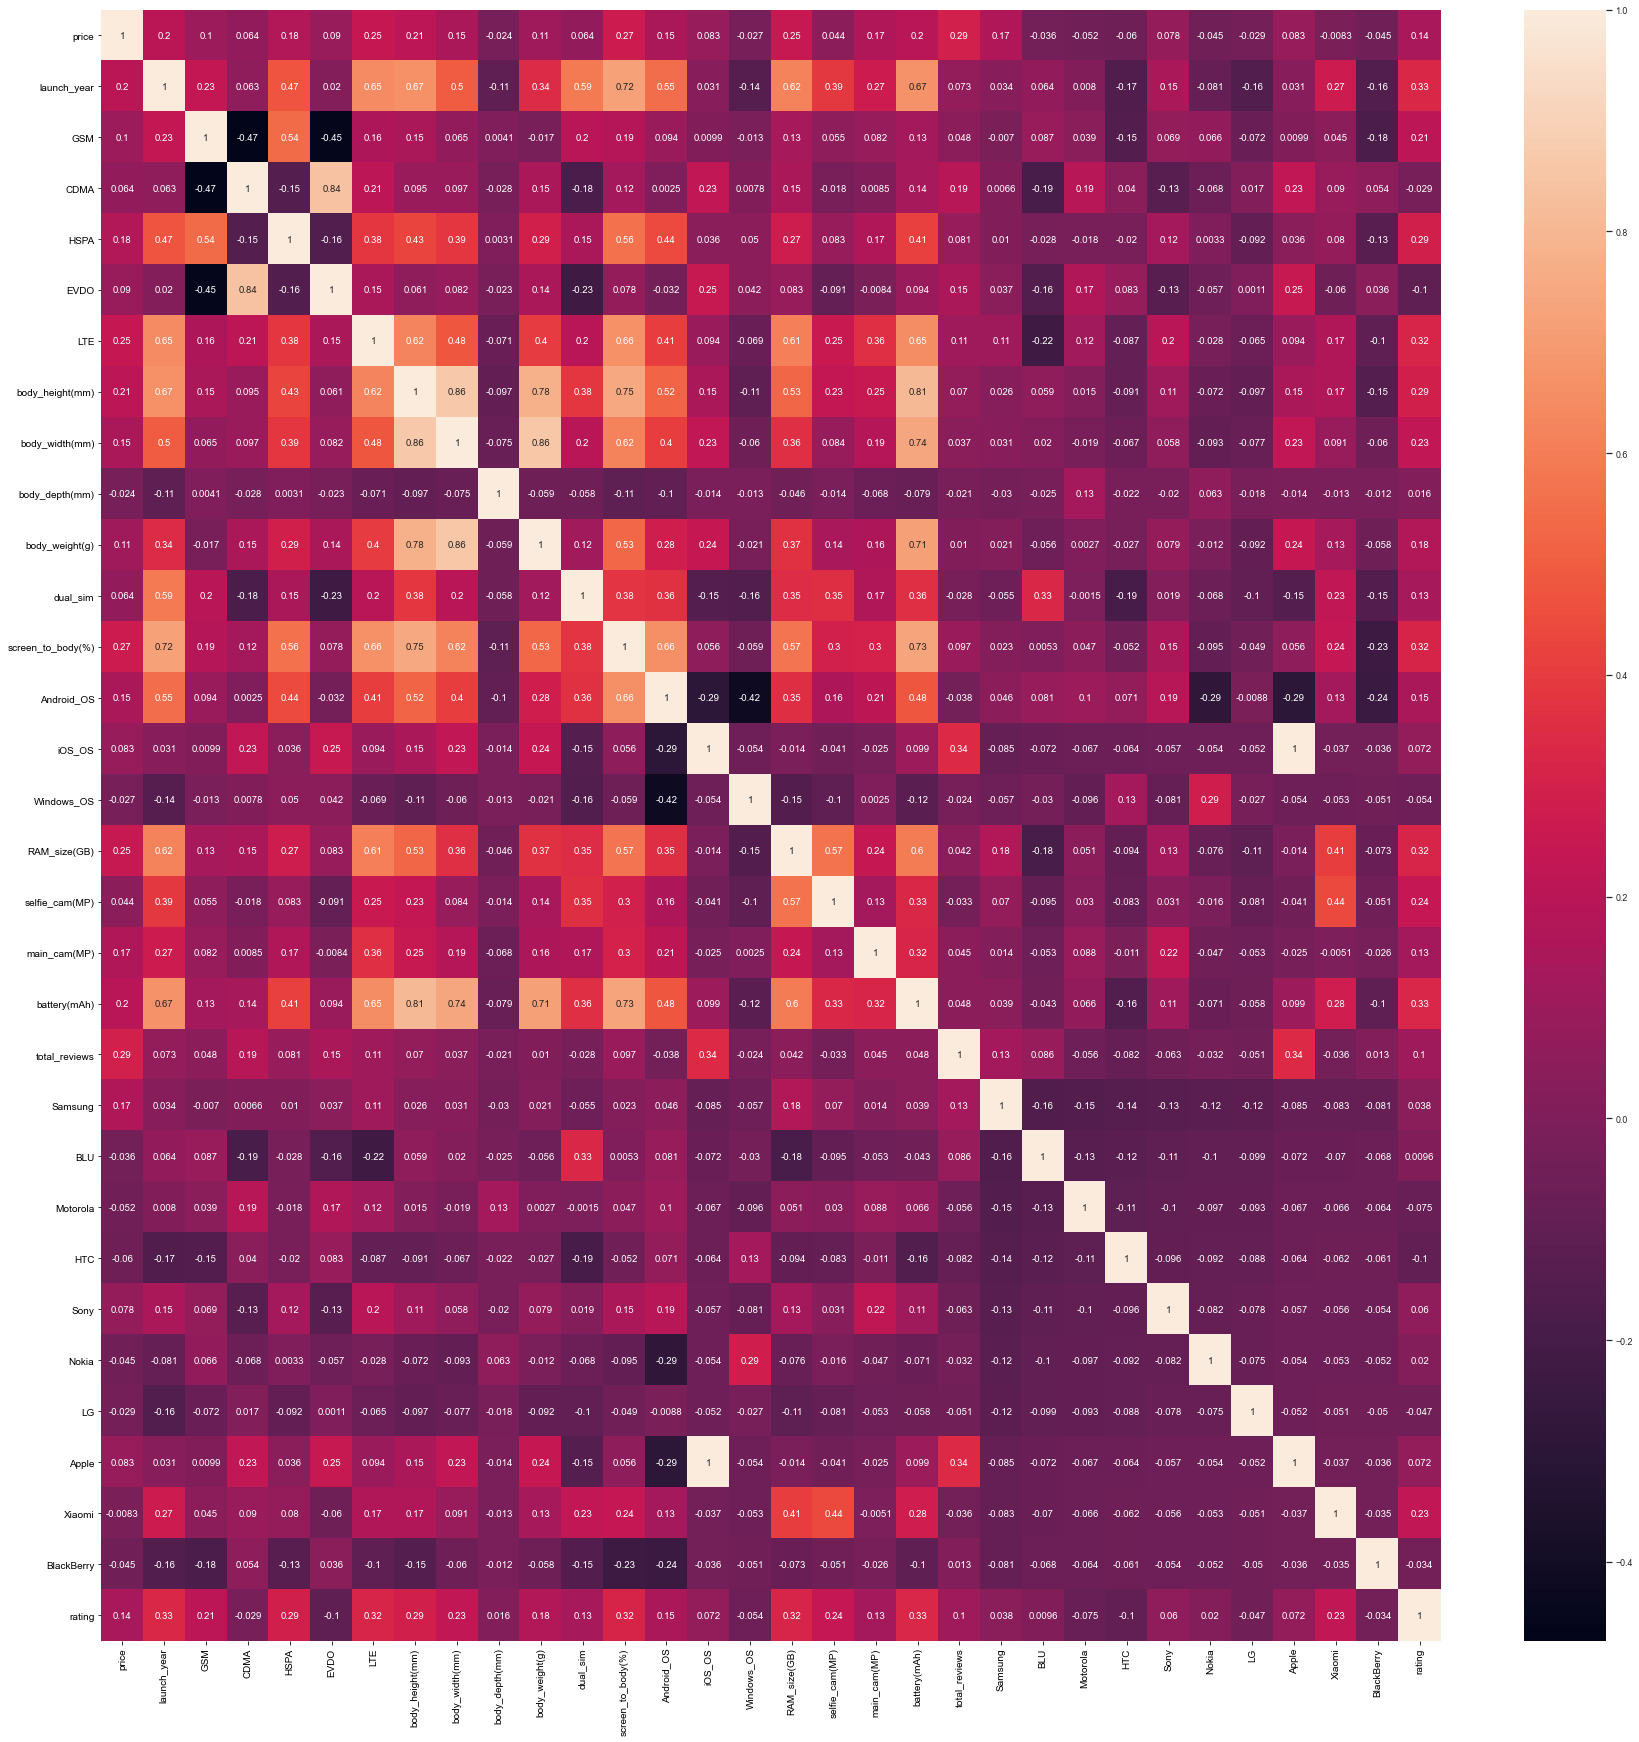

In [11]:
# Study the direct correlations between the features and the rating
df_corr = df_with_brands.corr()
# plot the coefficients
plt.figure()
plt.subplots(figsize=(30,30))
sns.set(font_scale=0.8)
sns.heatmap(df_corr, annot=True) 
plt.show()

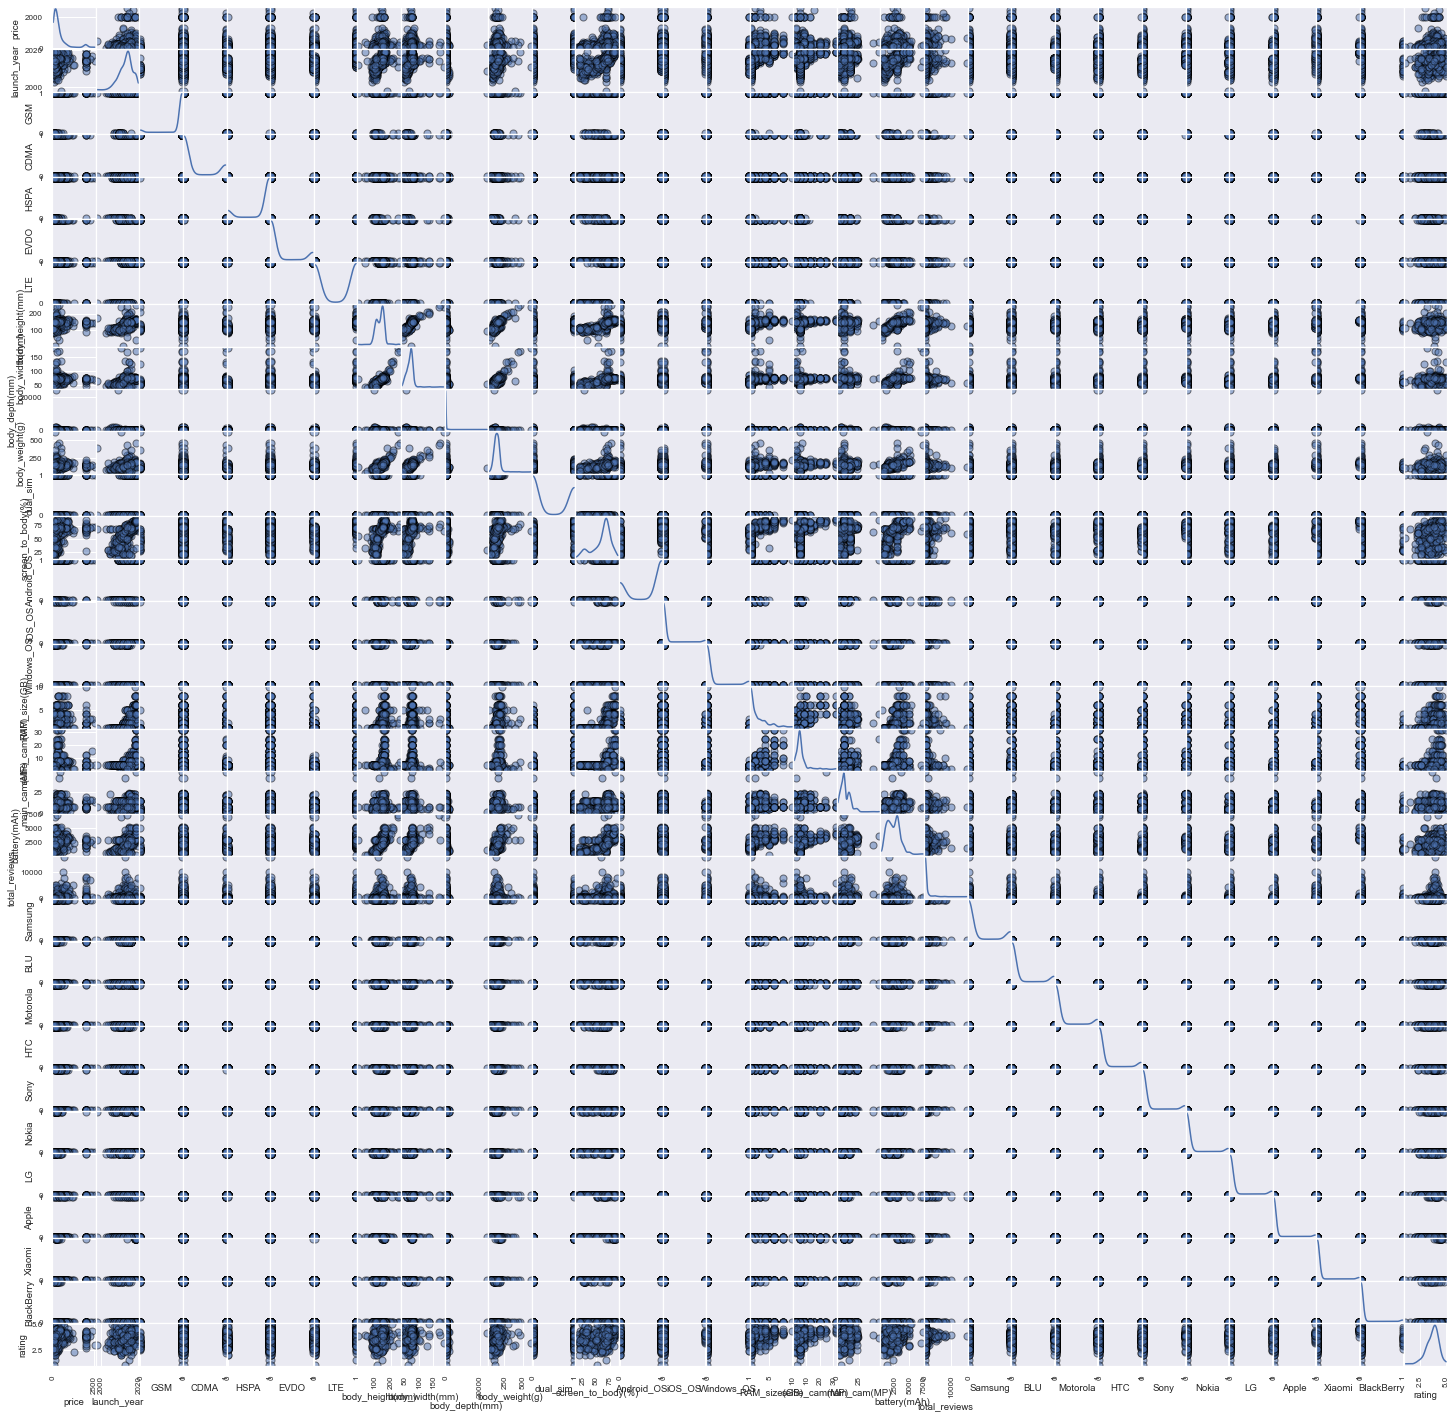

In [12]:
# Discover the correlations between the features
pd.plotting.scatter_matrix(df_with_brands,alpha=0.5, diagonal='kde', figsize=[25, 25],s=200,marker='.',edgecolor='black')
plt.show()

In [13]:
# Create a dict for the features to find the distances between them and rating column
features_dict = {}
features_cols= list(df_with_brands.columns)

for col in features_cols:
    # Compute the distance
    features_dict[col] = dc(df_with_brands[col], df_with_brands['rating'])
    
# Sort the features to find the nearest to rating column
features_dict = sorted(features_dict.items(),key=operator.itemgetter(1))    
features_dict

[('rating', 0.0),
 ('launch_year', 0.6692919168056076),
 ('battery(mAh)', 0.6745369351405037),
 ('LTE', 0.6814614073539704),
 ('RAM_size(GB)', 0.6817662266416289),
 ('screen_to_body(%)', 0.6840283812916044),
 ('HSPA', 0.7090118836634166),
 ('body_height(mm)', 0.7121094769278971),
 ('selfie_cam(MP)', 0.7587677118566603),
 ('body_width(mm)', 0.7723375712594138),
 ('Xiaomi', 0.7731288511807721),
 ('GSM', 0.7881531814934198),
 ('body_weight(g)', 0.8227792342486805),
 ('Android_OS', 0.8477794757914773),
 ('price', 0.8590695738169232),
 ('dual_sim', 0.8669480692188715),
 ('main_cam(MP)', 0.8681617832029552),
 ('total_reviews', 0.8954349433457343),
 ('iOS_OS', 0.9275189799640777),
 ('Apple', 0.9275189799640777),
 ('Sony', 0.9399405718981425),
 ('Samsung', 0.9617647254524575),
 ('Nokia', 0.9801682542089438),
 ('body_depth(mm)', 0.9836078217385361),
 ('BLU', 0.9904459525773076),
 ('CDMA', 1.0285806989506163),
 ('BlackBerry', 1.0343884300629014),
 ('LG', 1.0473766332774381),
 ('Windows_OS', 1.05

### Create the model and find important features

In [14]:
# Make trial X to have all features
X_T = df_with_brands.drop('rating',axis=1)
Y_T = df_with_brands['rating']

In [15]:
# Split dataset to train and test dfs
x_train_t, x_test_t, y_train_t, y_test_t = train_test_split(X_T, Y_T, test_size=0.2, random_state=10)

price : Score:  0.08885018680815249
launch_year : Score:  0.0005470848354309277
GSM : Score:  0.0
CDMA : Score:  0.0
HSPA : Score:  0.0
EVDO : Score:  0.0
LTE : Score:  0.0
body_height(mm) : Score:  0.004282778215323446
body_width(mm) : Score:  0.001178488552711693
body_depth(mm) : Score:  0.004039162416563153
body_weight(g) : Score:  0.009654158899920866
dual_sim : Score:  0.0
screen_to_body(%) : Score:  0.0014631879119234247
Android_OS : Score:  0.0
iOS_OS : Score:  0.0
Windows_OS : Score:  0.0
RAM_size(GB) : Score:  0.0
selfie_cam(MP) : Score:  -0.0008163374668700762
main_cam(MP) : Score:  0.0007345013638971554
battery(mAh) : Score:  0.16325709462102783
total_reviews : Score:  0.06261685880321588
Samsung : Score:  0.0
BLU : Score:  0.0
Motorola : Score:  0.0
HTC : Score:  0.0
Sony : Score:  0.0
Nokia : Score:  0.0
LG : Score:  0.0
Apple : Score:  0.0
Xiaomi : Score:  0.0
BlackBerry : Score:  0.0


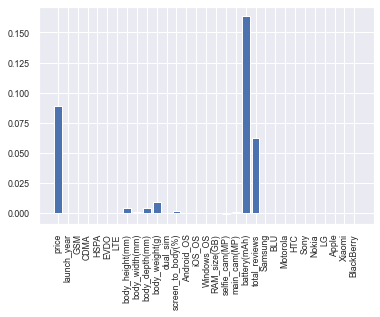

In [16]:
# Define the model
model = KNeighborsRegressor()
# Fit the model
model.fit(x_train_t, y_train_t)
# Perform permutation importance
results = permutation_importance(model, x_train_t, y_train_t, scoring='neg_mean_squared_error')
# Get importance
importance = results.importances_mean
# Summarize feature importance
for i,v in enumerate(importance):
    print(x_train_t.columns[i],': Score: ',v)
# Plot feature importance
x_range = range(len(importance))
x_labels = x_train_t.columns
plt.bar([x for x in x_range], importance)
plt.xticks(x_range, x_labels, rotation='vertical')
plt.show()

In [17]:
# Set the X to have the most important features
X = df_with_brands[['price','body_weight(g)','battery(mAh)']]
Y = df_with_brands['rating']

In [18]:
# Re-split after updating the X and Y
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)
model.fit(x_train, y_train)

KNeighborsRegressor()

In [19]:
def predict_and_find_rmse(model,x_true, y_true):
    
    '''
    INPUT 
        x_true: x of the y needs to be evaluated
        y_true: true y values
        
    OUTPUT
        Predict the values from the fitted model and prints the root of 
        the mean_squared_error of the predicted vs. the true values
    '''
    y_pred = model.predict(x_true)
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    print(rmse)

In [20]:
# Get the root of the mean_squared_error for train
predict_and_find_rmse(model,x_train, y_train)

0.4459117853320212


In [21]:
# Get the root of the mean_squared_error for test
predict_and_find_rmse(model,x_test, y_test)

0.5489665172980094


### Model Optimization

To be able to optimize the model used, three techniques will be applied to achieve the least error

1. Re-scale the features using logarithmic transformation and MinMaxScaler
2. Apply GridSearch to find the best parameters for the model
3. Push KNN to its maximum performance using bagging (BaggingRegressor)

In [22]:
# Re-split to apply refinements
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(X, Y, test_size=0.2, random_state=10)

In [23]:
def transform_data(df):
    
    '''
    INPUT 
        df: Features dataframe
        
    OUTPUT
        df_log_transform: Dataframe after applying the log transformation
    '''
    df_log_transform = pd.DataFrame(data=df)
    df_log_transform = df.apply(lambda x: np.log(x+1))
    
    return df_log_transform

In [24]:
# Define the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the x_train
x_train_log = transform_data(x_train_2)
x_train_scaled = scaler.fit_transform(x_train_log)
x_train_fitted = pd.DataFrame(x_train_scaled, columns=x_train_log.columns)

# Fit and transform the x_test
x_test_log = transform_data(x_test_2)
x_test_scaled = scaler.transform(x_test_log)
x_test_fitted = pd.DataFrame(x_test_scaled, columns=x_test_log.columns)

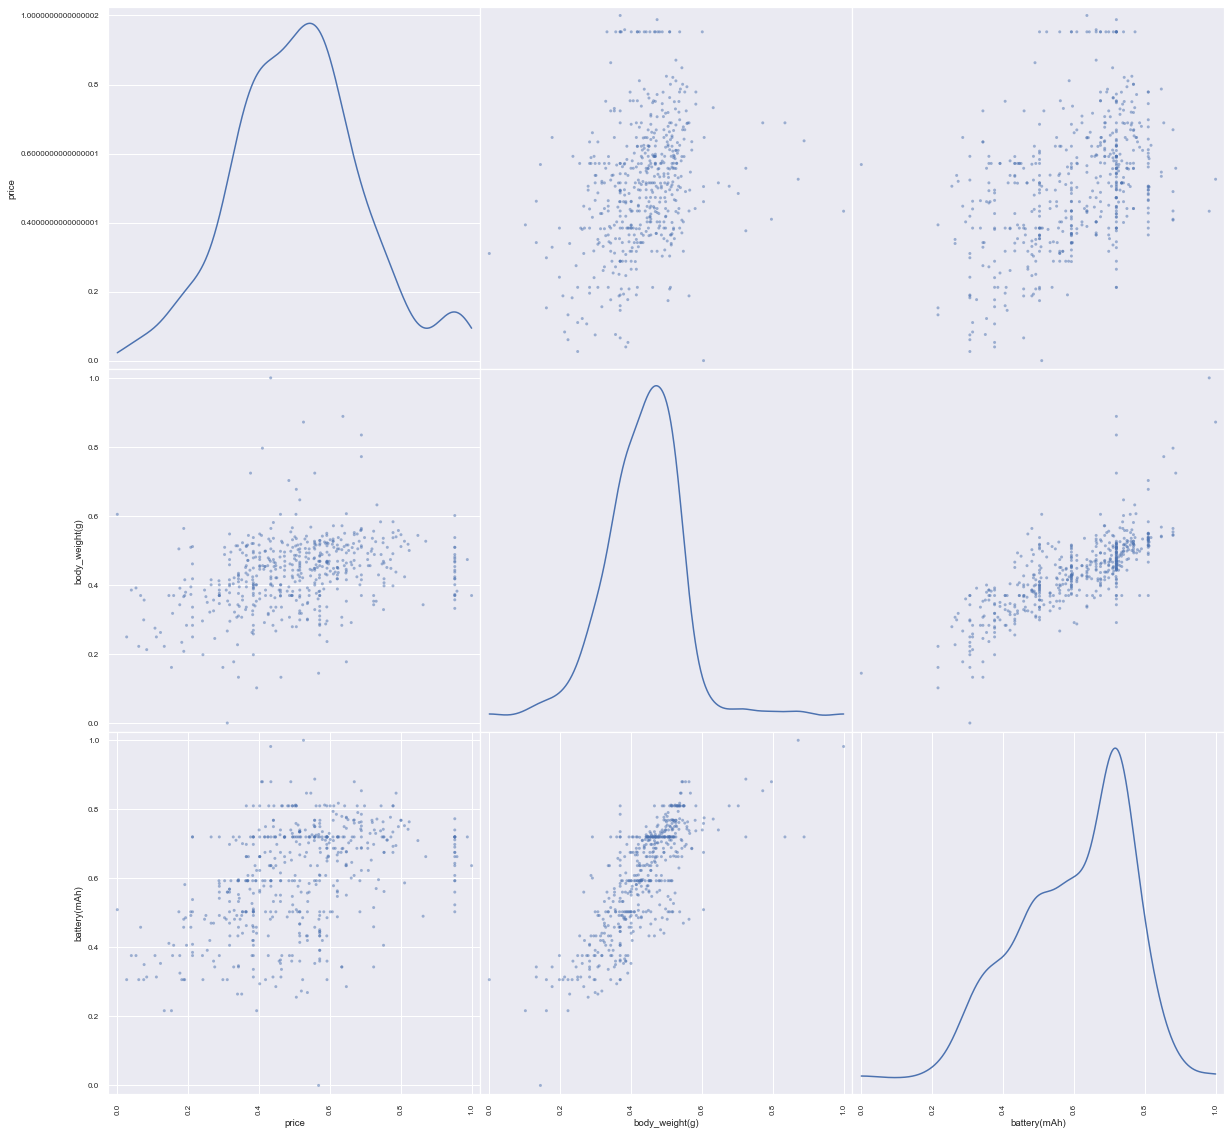

In [25]:
# Plot the training features data after transformation
pd.plotting.scatter_matrix(x_train_fitted, diagonal='kde', figsize=(20, 20))
plt.show()

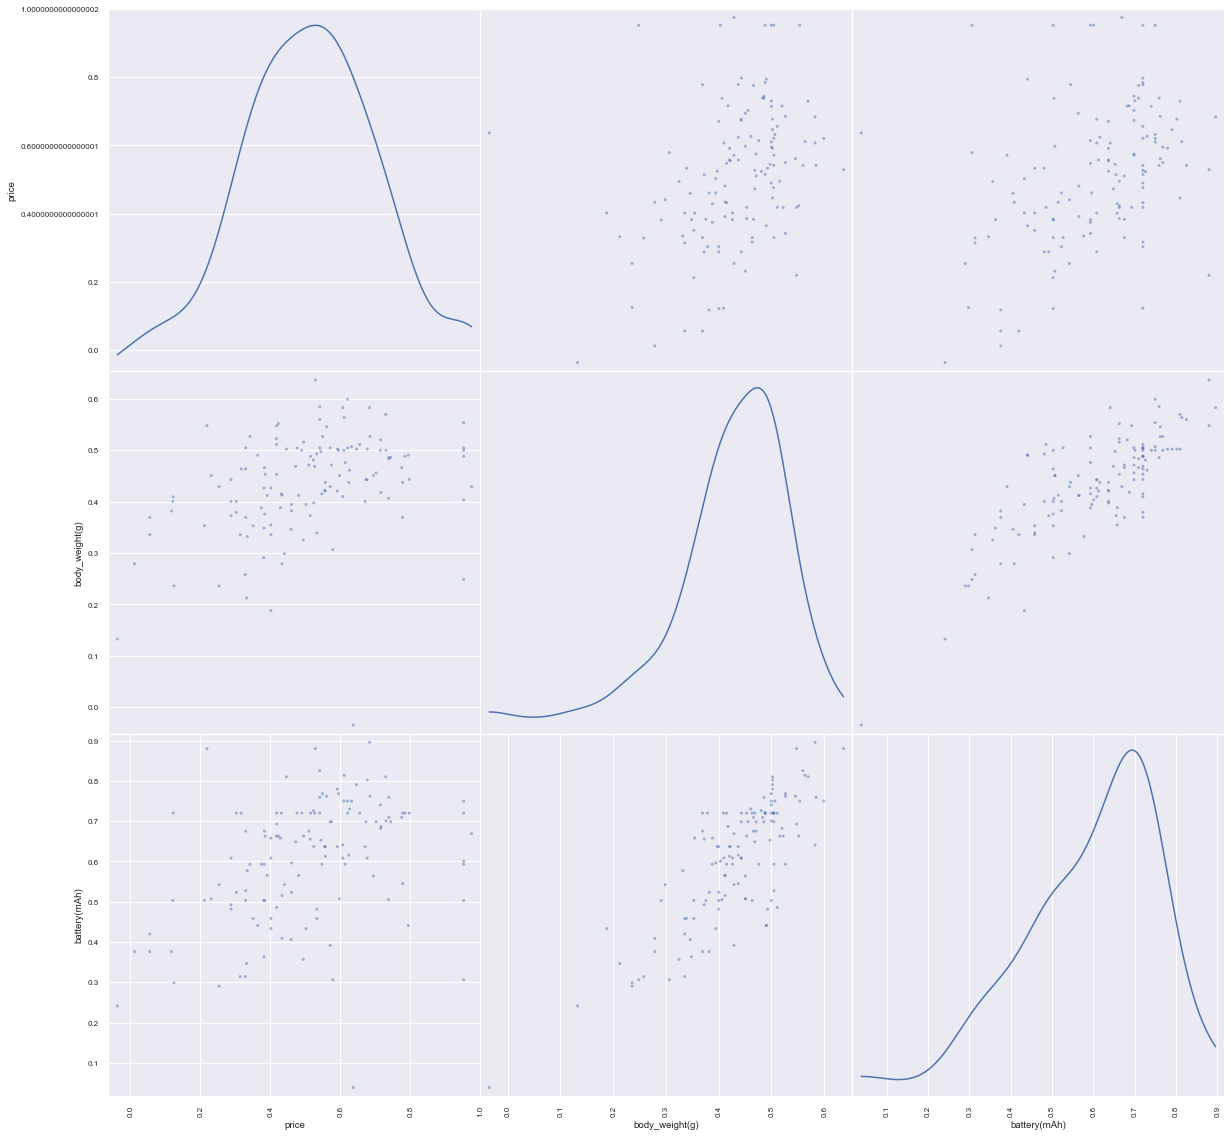

In [26]:
# Plot the testing features data after transformation
pd.plotting.scatter_matrix(x_test_fitted, diagonal='kde', figsize=(20, 20))
plt.show()

In [27]:
# Define parameters for gridsearch
parameters = {'n_neighbors': range(1, 50),
              'weights': ['uniform', 'distance']}
# Apply gridsearch on the KNN Regressor model
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
gridsearch.fit(x_train_fitted, y_train_2)
# Print the best parameters
gridsearch.best_params_

{'n_neighbors': 38, 'weights': 'distance'}

In [28]:
# Get the root of the mean_squared_error for train
print('train rmse:')
predict_and_find_rmse(gridsearch,x_train_fitted, y_train_2)
# Get the root of the mean_squared_error for test
print('test rmse:')
predict_and_find_rmse(gridsearch,x_test_fitted, y_test_2)

train rmse:
0.010510348323959941
test rmse:
0.5467821023961459


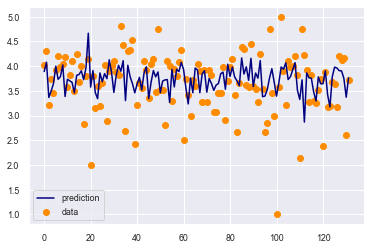

In [29]:
# Get predicted values
test_preds_grid = gridsearch.predict(x_test_fitted)
# Plot the true values vs. the predicted
plt.scatter([x for x in range(len(x_test_fitted))], y_test_2, color='darkorange', label='data')
plt.plot([x for x in range(len(x_test_fitted))], test_preds_grid, color='navy', label='prediction')
plt.legend()
plt.show()

In [30]:
# Apply the best parameters from gridsearch
best_k = gridsearch.best_params_["n_neighbors"]
best_weights = gridsearch.best_params_["weights"]
bagged_knn = KNeighborsRegressor(n_neighbors=best_k, weights=best_weights)

In [31]:
# Initialize the BaggingRegressor and find the root of the mean_squared_error
bagging_model = BaggingRegressor(bagged_knn, n_estimators=100)
bagging_model.fit(x_train_fitted, y_train_2)
predict_and_find_rmse(bagging_model,x_test_fitted, y_test_2)

0.5421535166726185


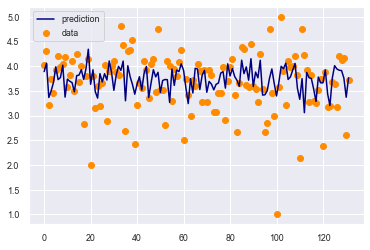

In [32]:
# Get predicted values
test_preds_grid2 = bagging_model.predict(x_test_fitted)
# Plot the true values vs. the final predictions
plt.scatter([x for x in range(len(x_test_fitted))], y_test_2, color='darkorange', label='data')
plt.plot([x for x in range(len(x_test_fitted))], test_preds_grid2, color='navy', label='prediction')
plt.legend()
plt.show()